In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from hydracv.midline import find_midline_midpoints, find_midline_midpoints_corrected
from hydracv.fluorescence import trace_fluo

In [12]:
VIDEONAME = "Control-EGCaMP_exp1_a2_25x10fps_30mins" # TO MODIFY

## Midline and length

Requirement: 
- contour
- tracked data (results from DeepLabCut)

In [28]:
FILE_CONTOUR = "./data/contour/" + VIDEONAME + ".xml" # TO MODIFY
FILE_MARKER = "./data/marker/Control-EGCaMP_exp1_a2_25x10fps_30minsDLC_resnet50_LType-Ctrl2Mar24shuffle1_360000.csv" # TO MODIFY

In [ ]:
# Original find midline code
midpoints_orig = find_midline_midpoints.find_midline(file_contour=FILE_CONTOUR,
                                                     file_marker=FILE_MARKER,
                                                     nseg=40,
                                                     play=False)

In [ ]:
# Save the original midpoints
FILE_MIDPOINTS = "./data/midpoints/" + VIDEONAME + "_midpoints.csv"
df = pd.DataFrame(midpoints_orig)
df.to_csv(FILE_MIDPOINTS, index=False)

In [ ]:
# Quality-improved version of midpoints
midpoints_corr = find_midline_midpoints_corrected.find_midline(file_contour=FILE_CONTOUR,
                                                                    file_marker=FILE_MARKER,
                                                                    file_midpoints=FILE_MIDPOINTS,
                                                                    nseg=40)

In [ ]:
# Save the corrected midpoints
FILE_MIDPOINTS_CORR = "./data/midpoints/" + VIDEONAME + "_midpoints_corrected.csv"
df = pd.DataFrame(midpoints_corr)
df.to_csv(FILE_MIDPOINTS_CORR, index=False)

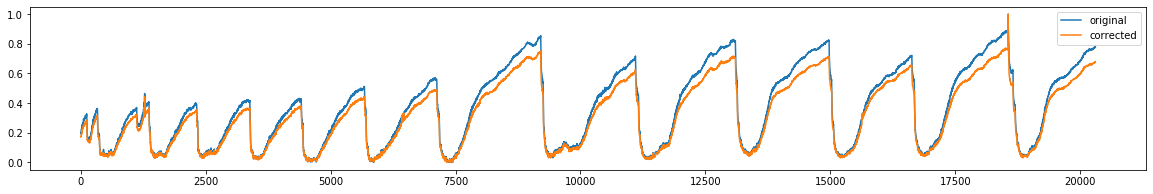

In [21]:
# Plot the length

midpoints_orig_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS)
midpoints_corr_data = find_midline_midpoints_corrected.load_midpoints(FILE_MIDPOINTS_CORR)

midlens_orig = find_midline_midpoints_corrected.extract_lengths(midpoints_orig_data)
midlens_corr = find_midline_midpoints_corrected.extract_lengths(midpoints_corr_data)

plt.figure(figsize=(20,3))
plt.plot(midlens_orig, label='original')
plt.plot(midlens_corr, label='corrected')
plt.legend()
plt.show()

In [ ]:
# Save the lengths
FILE_LENGTH = "./data/length/lengths_" + VIDEONAME + ".csv"
df = pd.DataFrame(midlens_corr)
df.to_csv(FILE_LENGTH, index=False)

## Fluorescence

Requirement: 
- video

In [24]:
FILE_VIDEO = "./data/videos/" + "EGCaMP/" + VIDEONAME + ".avi" # TO MODIFY

In [25]:
# Trace fluorescence
fluo = trace_fluo.trace(FILE_VIDEO, display=False)

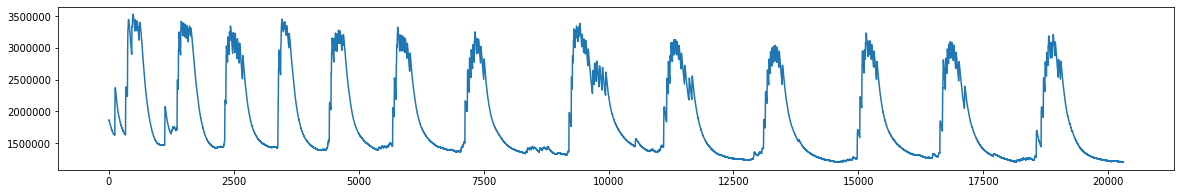

In [26]:
# Plot fluorescence
plt.figure(figsize=(20,3))
plt.plot(fluo)
plt.show()

In [27]:
# Save the results
FILE_FLUO = "./data/fluorescence/"

df = pd.DataFrame(fluo)
df.to_csv(FILE_FLUO + 'total_fluo_' + VIDEONAME + '.csv', index=False)